In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [17]:
# ---------------------------
# Step 1: Define Parameters
# ---------------------------

In [18]:
img_width, img_height = 64, 64
batch_size = 128  # Adjust epochs based on your needs
validation_split = 0.2  # Use 20% of the data for validation

# Path to the dataset directory.
# The directory should contain two subdirectories: 'yawn' and 'no_yawn'
dataset_dir = '/home/dhruv/Driver_Drowsiness_detection(CNN multithreading)/data/yawn_data/'  # Replace with your dataset path

In [19]:
# ----------------------------------------
# Step 2: Data Preparation and Augmentation
# ----------------------------------------

In [20]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,         # Increase rotation for more diversity
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=validation_split
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=validation_split
)

# Create training and validation generators.
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 1728 images belonging to 2 classes.
Found 431 images belonging to 2 classes.


In [10]:
# --------------------------------------
# Step 3: Build and Compile the Model
# --------------------------------------

In [30]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/home/dhruv/AnacondaInstallation/envs/tf-env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,272,833 (4.86 MB)

 Trainable params: 1,272,833 (4.86 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# ---------------------------------
# Step 4: Train the CNN Model
# ---------------------------------

In [31]:
# The generator's "classes" attribute contains labels for each image.
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
# Create a dictionary mapping class indices to weights.
class_weights = dict(enumerate(class_weights_array))
print("Computed Class Weights:", class_weights)


Computed Class Weights: {0: 0.9773755656108597, 1: 1.0236966824644549}


In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

epochs = 30  # Increase the number of epochs

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    class_weight=class_weights,  # Already computed weights
    callbacks=callbacks
)


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.5532 - loss: 0.6644
Epoch 1: val_loss improved from inf to 0.24025, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 526ms/step - accuracy: 0.5594 - loss: 0.6606 - val_accuracy: 0.9766 - val_loss: 0.2403 - learning_rate: 0.0010
Epoch 2/30
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7656 - loss: 0.5065

/home/dhruv/AnacondaInstallation/envs/tf-env/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.24025
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7656 - loss: 0.5065 - val_accuracy: 0.8646 - val_loss: 0.3149 - learning_rate: 0.0010
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7864 - loss: 0.4486
Epoch 3: val_loss did not improve from 0.24025
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.7888 - loss: 0.4452 - val_accuracy: 0.7995 - val_loss: 0.3393 - learning_rate: 0.0010
Epoch 4/30
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8984 - loss: 0.2789
Epoch 4: val_loss did not improve from 0.24025

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8984 - loss: 0.2789 - val_accuracy: 0.6302 - val_loss: 0.5301 - learning_rate: 0.0010
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.8727 - loss: 0.2765
Epoch 5: val_loss improved from 0.24025 to 0.19498, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - accuracy: 0.8756 - loss: 0.2732 - val_accuracy: 0.9323 - val_loss: 0.1950 - learning_rate: 5.0000e-04
Epoch 6/30
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9766 - loss: 0.0941
Epoch 6: val_loss improved from 0.19498 to 0.16374, saving model to best_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9766 - loss: 0.0941 - val_accuracy: 0.9401 - val_loss: 0.1637 - learning_rate: 5.0000e-04
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9526 - loss: 0.1621
Epoch 7: val_loss did not improve from 0.16374
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.9529 - loss: 0.1604 - val_accuracy: 0.8880 - val_loss: 0.3305 - learning_rate: 5.0000e-04
Epoch 8/30
 1/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9531 - loss: 0.1177
Epoch 8: val_loss did not improve from 0.16374
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9531 - loss: 0.1177 - val_accuracy: 0.9115 - val_loss: 0.2802 - learning_rate: 5.0000e-04
Epoch 9/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9775 - loss: 0.0894
Epoch 9: val_loss did not improve from 0.16374

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.9767 - loss: 0.0909 - val_accuracy: 0

In [ ]:
# --------------------------------------------
# Step 5: Plot Training and Validation Accuracy
# --------------------------------------------

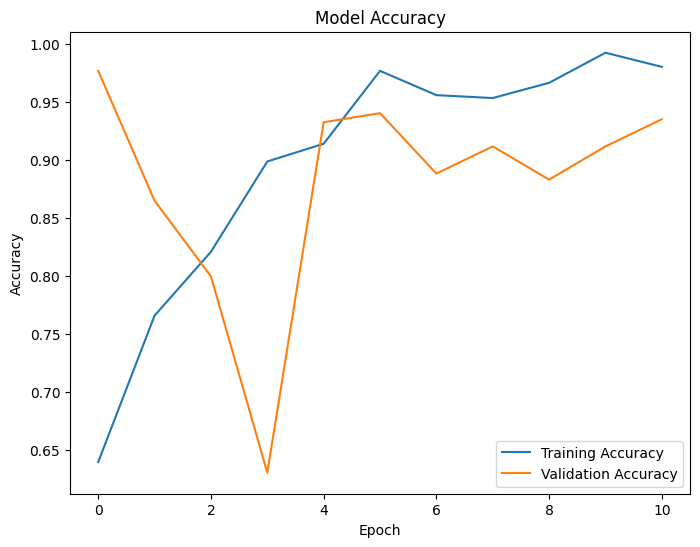

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# -----------------------------------------------------------
# Step 6: Evaluate the Model with Confusion Matrix and Report
# -----------------------------------------------------------

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step
Confusion Matrix:
[[197  23]
 [  0 211]]
Classification Report:
              precision    recall  f1-score   support

     no_yawn       1.00      0.90      0.94       220
        yawn       0.90      1.00      0.95       211

    accuracy                           0.95       431
   macro avg       0.95      0.95      0.95       431
weighted avg       0.95      0.95      0.95       431



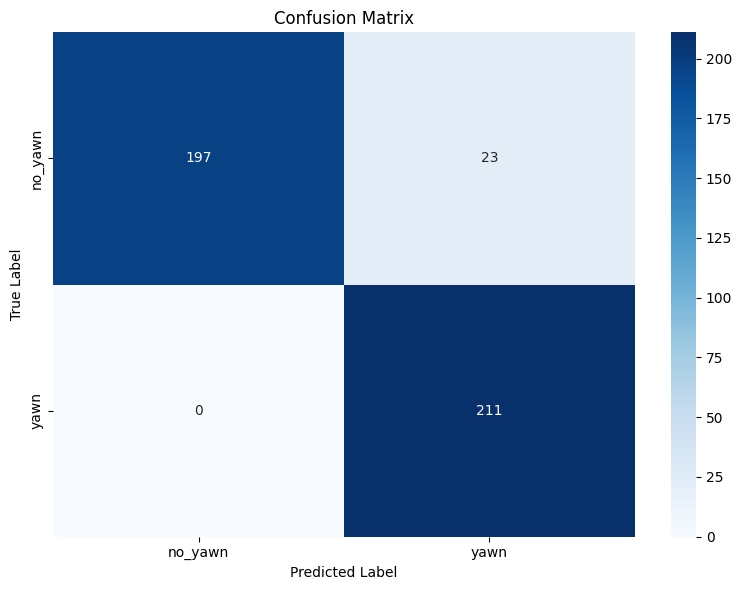

In [34]:
val_generator.reset()

predictions = model.predict(val_generator, steps=(val_generator.samples // batch_size) + 1)
predicted_classes = np.where(predictions.flatten() > 0.5, 1, 0)

true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Generate and save a confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()